In [54]:
import pycbc
from pycbc.psd import analytical
from matplotlib import pyplot as plt
import numpy as np

In [549]:
psds_to_plot = [psd for psd in analytical.get_lalsim_psd_list() if 'instein' in psd or 'osmic' in psd]
psds_to_plot += ['aLIGOZeroDetHighPowerGWINC']

print(psds_to_plot)

psd_cutoffs = [1, 6, 1, 1, 10]

['CosmicExplorerP1600143', 'CosmicExplorerPessimisticP1600143', 'CosmicExplorerWidebandP1600143', 'EinsteinTelescopeP1600143', 'aLIGOZeroDetHighPowerGWINC']


Text(0, 0.5, 'PSD, Hz$^{-1}$')

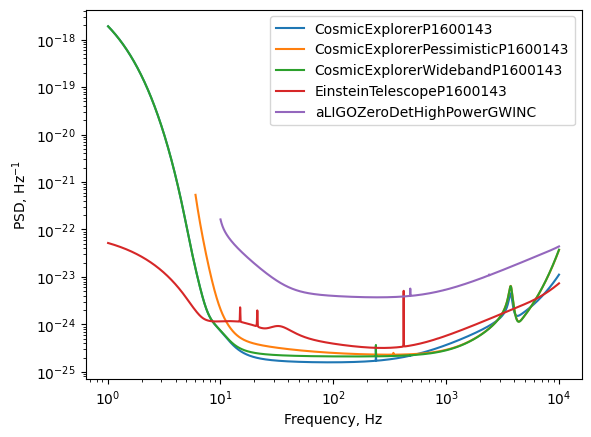

In [85]:
for psd, cutoff in zip(psds_to_plot, psd_cutoffs):
    flower = 5 if 'LIGO' in psd else 0.5
    psd_fs = analytical.from_string(psd, 1000000, 0.01, flower)
    nz = np.logical_and(abs(psd_fs) > 0, psd_fs.sample_frequencies > cutoff)
    plt.plot(psd_fs.sample_frequencies[nz], np.sqrt(abs(psd_fs[nz])), label=psd)

plt.loglog()
plt.legend()
plt.xlabel('Frequency, Hz')
plt.ylabel('PSD, Hz$^{-1}$')

In [20]:
# Get the Strain ASDs for CE from https://dcc.cosmicexplorer.org/cgi-bin/DocDB/ShowDocument?docid=T2000017

# Import the requests and zipfile modules
import requests
import zipfile
import os

out_dir = "download"

# Create the download directory if it does not exist
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

link = "https://dcc.cosmicexplorer.org/public/0163/T2000017/007/ce_strain.zip"
zipfile_name = link.split("/")[-1]
zipfile_path = os.path.join(out_dir, zipfile_name)

if not os.path.exists(zipfile_path):
    print("Downloading {}...".format(zipfile_name))
    # Download the zip file as a binary stream
    response = requests.get(link, stream=True)

    # Save the zip file to a local file
    with open(zipfile_path, "wb") as f:
        # Write the response content to the file
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

# Create a zipfile object from the local file
zip_obj = zipfile.ZipFile(zipfile_path)


if not os.path.exists(out_dir):
    os.mkdir(out_dir)

zip_obj.extractall(out_dir)

# Close the zipfile object
zip_obj.close()

zipfolder = os.path.join(zipfile_path.split(".")[0])

ce_strainfiles = [os.path.join(zipfolder, f) for f in os.listdir(zipfolder) if f.endswith('_strain.txt')]

In [556]:
ce_data = []
for i in range(len(ce_strainfiles)):
    ce_strain_path = ce_strainfiles[i]
    ce_strain_filename = ce_strain_path.split("/")[-1].split(".")[0]
    ce_strain = np.loadtxt(ce_strain_path)
    ce_fx = ce_strain[:,0]
    ce_asd = ce_strain[:,1]
    ce_cutoff = 6
    ce_psd = pycbc.psd.read.from_numpy_arrays(ce_fx, ce_asd, delta_f=0.01, length = 500000, low_freq_cutoff=ce_cutoff)
    ce_data.append(np.array([ce_strain_filename, ce_psd, ce_cutoff], dtype=object))
ce_data = np.vstack(ce_data)

In [566]:
psds_to_plot = ['CosmicExplorerP1600143', \
'CosmicExplorerPessimisticP1600143',\
'CosmicExplorerWidebandP1600143',\
'EinsteinTelescopeP1600143',\
'aLIGOZeroDetHighPowerGWINC']

['CosmicExplorerP1600143',
 'CosmicExplorerPessimisticP1600143',
 'CosmicExplorerWidebandP1600143',
 'EinsteinTelescopeP1600143',
 'aLIGOZeroDetHighPowerGWINC']

In [573]:
def plot_psd(psds_to_plot, psd_cutoffs):
    fig = plt.figure()
    for psd, cutoff in zip(psds_to_plot, psd_cutoffs):
        if type(psd) == str:
            flower = 5 if 'LIGO' in psd else 0.5
            psd_fs = analytical.from_string(psd, 1000000, 0.01, flower)
            nz = np.logical_and(abs(psd_fs) > 0, psd_fs.sample_frequencies > cutoff)
            plt.plot(psd_fs.sample_frequencies[nz], np.sqrt(abs(psd_fs[nz])), label=psd, alpha=0.33)
        elif type(psd) == list:
            psd_name = psd[0]
            psd_fs = psd[1]
            nz = np.logical_and(abs(psd_fs) > 0, psd_fs.sample_frequencies > cutoff)
            plt.plot(psd_fs.sample_frequencies[nz], psd_fs[nz], label=psd_name, linewidth=2, color='black')
    plt.loglog()
    plt.legend()
    plt.xlabel('Frequency, Hz')
    plt.ylabel('PSD, Hz$^{-1}$')
    plt.show()
    fig.clear()

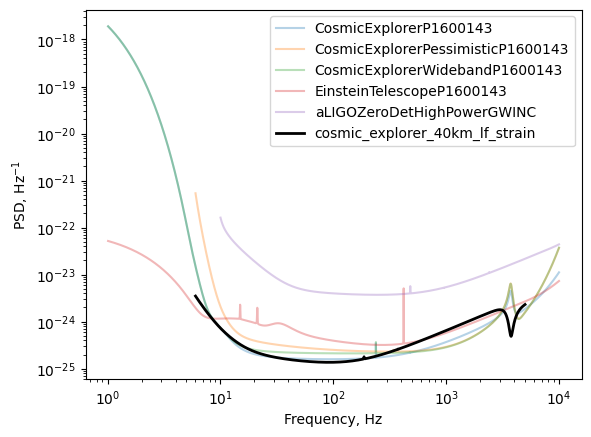

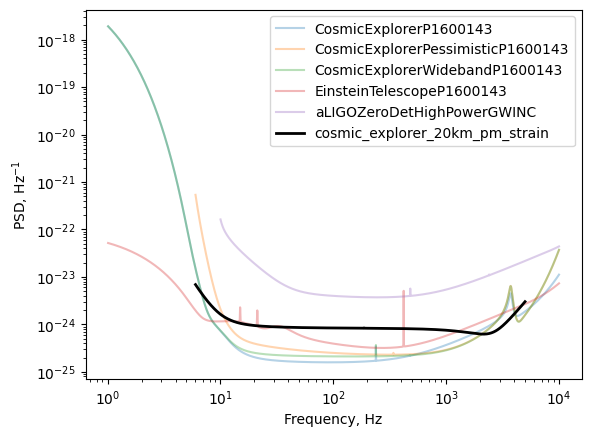

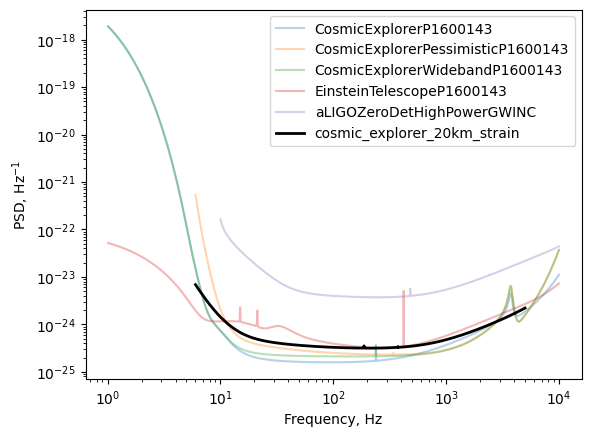

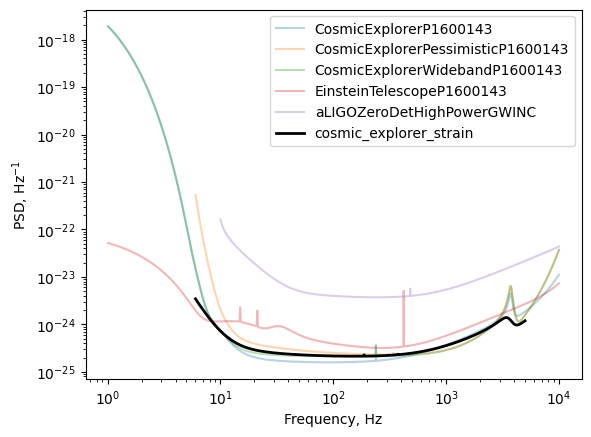

In [574]:
for i in range(len(ce_data)):
    psds_mod = psds_to_plot + [ce_data[i,:2].tolist()]
    psd_cutoffs_mod = psd_cutoffs + [ce_data[i,2]]
    plot_psd(psds_mod, psd_cutoffs_mod)